In [1]:
import sys

sys.path.append("..")

In [2]:
import time
from functools import partial
from tempfile import TemporaryDirectory
from pathlib import Path
from textwrap import fill

import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from tests.raster_processing.clip_test import raster_path as SMALL_RASTER_PATH
from eis_toolkit.raster_processing.distance_to_anomaly import (
    distance_to_anomaly,
    distance_to_anomaly_gdal_ComputeProximity,
    _fits_criteria,
    distance_to_anomaly_gdal,
)

In [3]:
def _plot_image(ax, data, title, transform):
    plot.show(data, transform=transform, ax=ax)
    plt.subplots_adjust(wspace=0.35, hspace=0.2)
    ax.set_title(fill(title, width=25))
    norm = plt.Normalize(vmax=np.nanmax(data), vmin=np.nanmin(data))
    cmap = matplotlib.cm.viridis
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)


def _plot_distance_example(threshold_criteria_value, threshold_criteria):
    fig, axes = plt.subplots(2, 3, figsize=(14, 10))
    axes = axes.flatten()

    with rasterio.open(SMALL_RASTER_PATH) as raster:
        raster_data = raster.read(1)
        raster_profile = raster.profile
    raster_transform = raster_profile["transform"]

    _plot_image_with_transform = partial(_plot_image, transform=raster_transform)

    _plot_image_with_transform(ax=axes[0], data=raster_data, title="All data")

    raster_data_fits_criteria = _fits_criteria(
        threshold_criteria_value=threshold_criteria_value,
        threshold_criteria=threshold_criteria,
        anomaly_raster_data=raster_data,
        nodata_value=raster_profile.get("nodata"),
    )
    raster_data_criteria = np.where(raster_data_fits_criteria, raster_data, np.nan)
    _plot_image_with_transform(
        ax=axes[1], data=raster_data_criteria, title="Data fitting criteria (anomaly)"
    )
    start_time = time.time()
    out_image,_ = distance_to_anomaly(
        anomaly_raster_data=raster_data,
        anomaly_raster_profile=raster_profile,
        threshold_criteria_value=threshold_criteria_value,
        threshold_criteria=threshold_criteria,
    )

    end_time = time.time()
    _plot_image_with_transform(
        ax=axes[3],
        data=out_image,
        title="Distance to nearest anomaly (distance_computation)",
    )
    print(f"The time taken by distance_to_anomaly function to calculate the distance to anomaly is = {end_time-start_time} seconds")

    start_time = time.time()
    out_image_ComputeProximity, out_meta = distance_to_anomaly_gdal_ComputeProximity(
        anomaly_raster_data=raster_data,
        anomaly_raster_profile=raster_profile,
        threshold_criteria_value=threshold_criteria_value,
        threshold_criteria=threshold_criteria,
    )

    end_time = time.time()
    _plot_image_with_transform(
        ax=axes[4],
        data=out_image_ComputeProximity,
        title="Distance to nearest anomaly (distance_computation_with_gdal.ComputeProximity)",
    )
    print(f"The time taken by gdal.ComputeProximity function to calculate the distance to anomaly is = {end_time-start_time} seconds")

    with TemporaryDirectory() as tmp_dir_str:
        distance_path = Path(tmp_dir_str) / "distance_to_anomaly_gdal.tif"
        try:
            start_time = time.time()
            distance_path = distance_to_anomaly_gdal(
                anomaly_raster_data=raster_data,
                anomaly_raster_profile=raster_profile,
                threshold_criteria_value=threshold_criteria_value,
                threshold_criteria=threshold_criteria,
                output_path=distance_path,
            )
            end_time = time.time()
            print(f"The time taken by gdal function to calculate the distance to anomaly is = {end_time-start_time} seconds")
            with rasterio.open(distance_path) as distance_raster:
                _plot_image_with_transform(
                    ax=axes[5],
                    data=distance_raster.read(1),
                    title="Distance to nearest anomaly (gdal_proximity.py)",
                )
        except ModuleNotFoundError as exc:
            print("distance_to_anomaly_gdal does not work on windows.")
            print(exc)
    fig.delaxes(axes[-4])
    

The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.24913668632507324 seconds
The time taken by gdal.ComputeProximity function to calculate the distance to anomaly is = 0.004995584487915039 seconds
The time taken by gdal function to calculate the distance to anomaly is = 0.06283402442932129 seconds


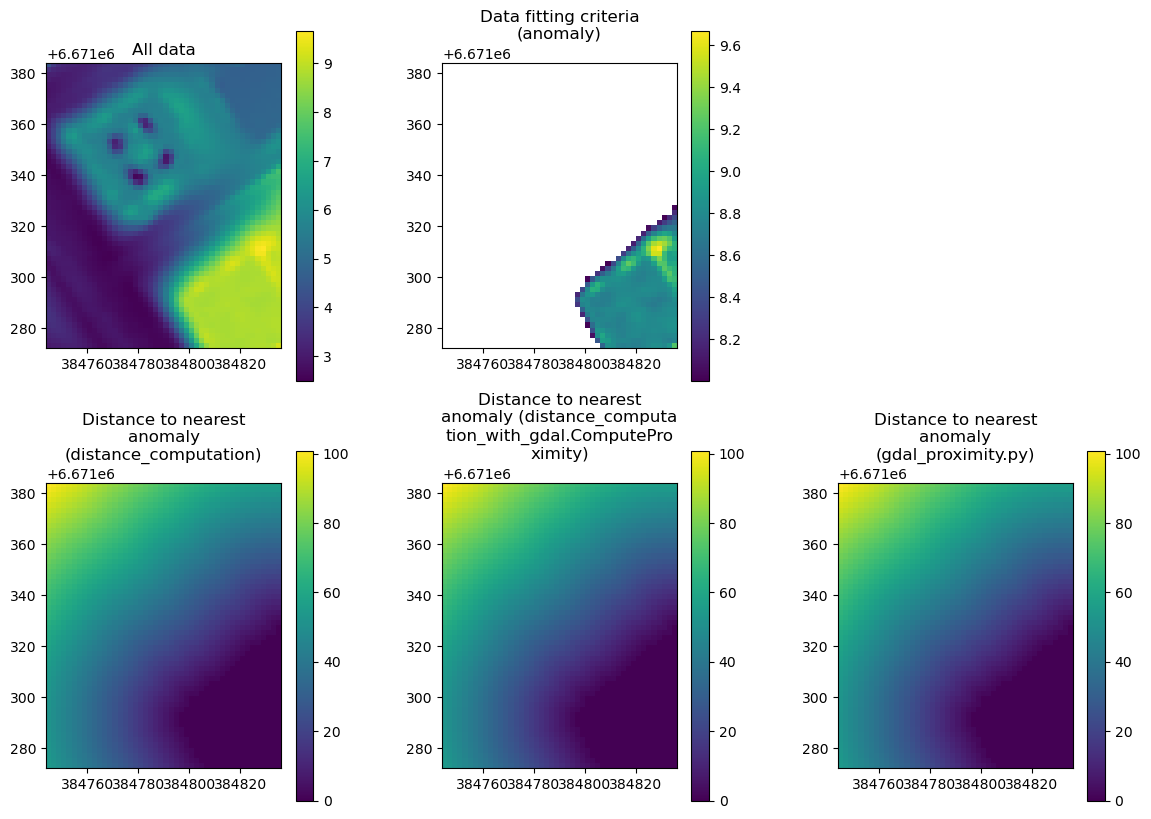

In [4]:
_plot_distance_example(threshold_criteria_value=8.0, threshold_criteria="higher")

In [5]:
import sys
sys.path.append("E:/EIS/aus_CMAAS_Projekt")
from beak.utilities.raster_processing import calculate_distance_from_raster


The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.6657772064208984 seconds
The time taken by gdal.ComputeProximity function to calculate the distance to anomaly is = 0.0009982585906982422 seconds
The time taken by gdal function to calculate the distance to anomaly is = 0.015784025192260742 seconds


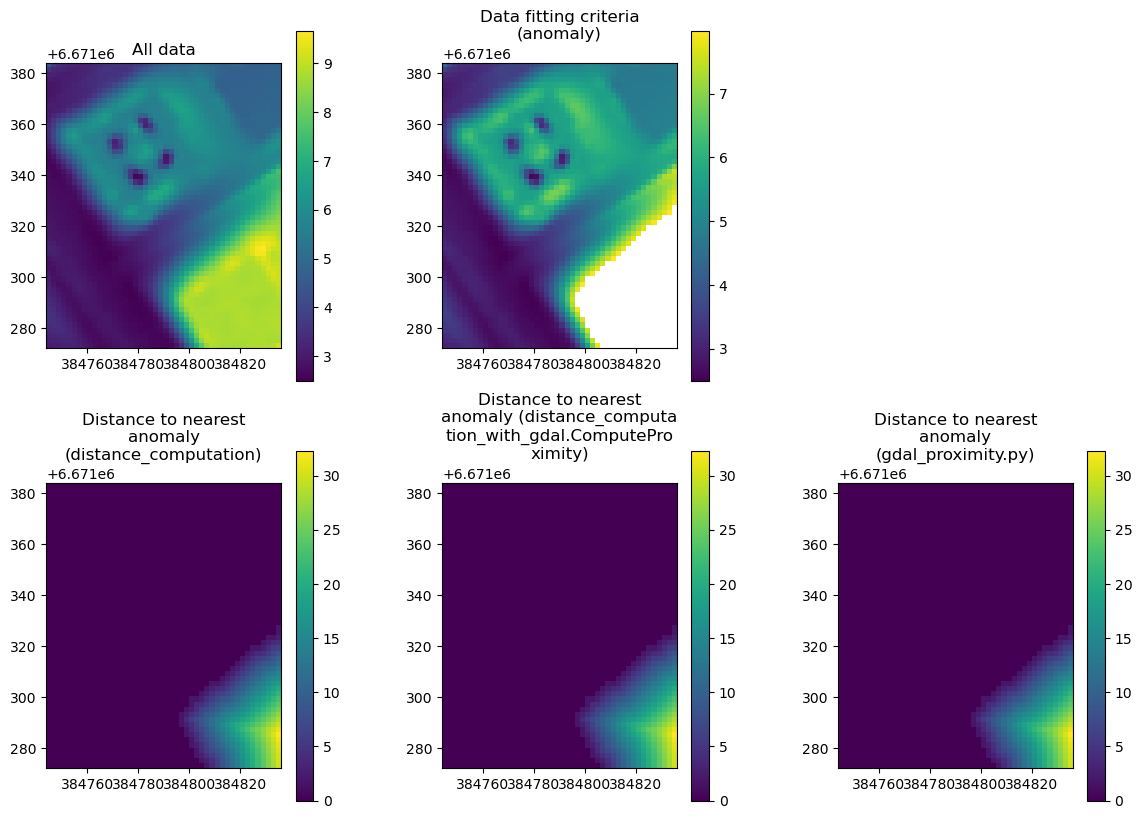

In [6]:
_plot_distance_example(threshold_criteria_value=8.0, threshold_criteria="lower")

The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.3461174964904785 seconds
The time taken by gdal.ComputeProximity function to calculate the distance to anomaly is = 0.009576559066772461 seconds
The time taken by gdal function to calculate the distance to anomaly is = 0.0170137882232666 seconds


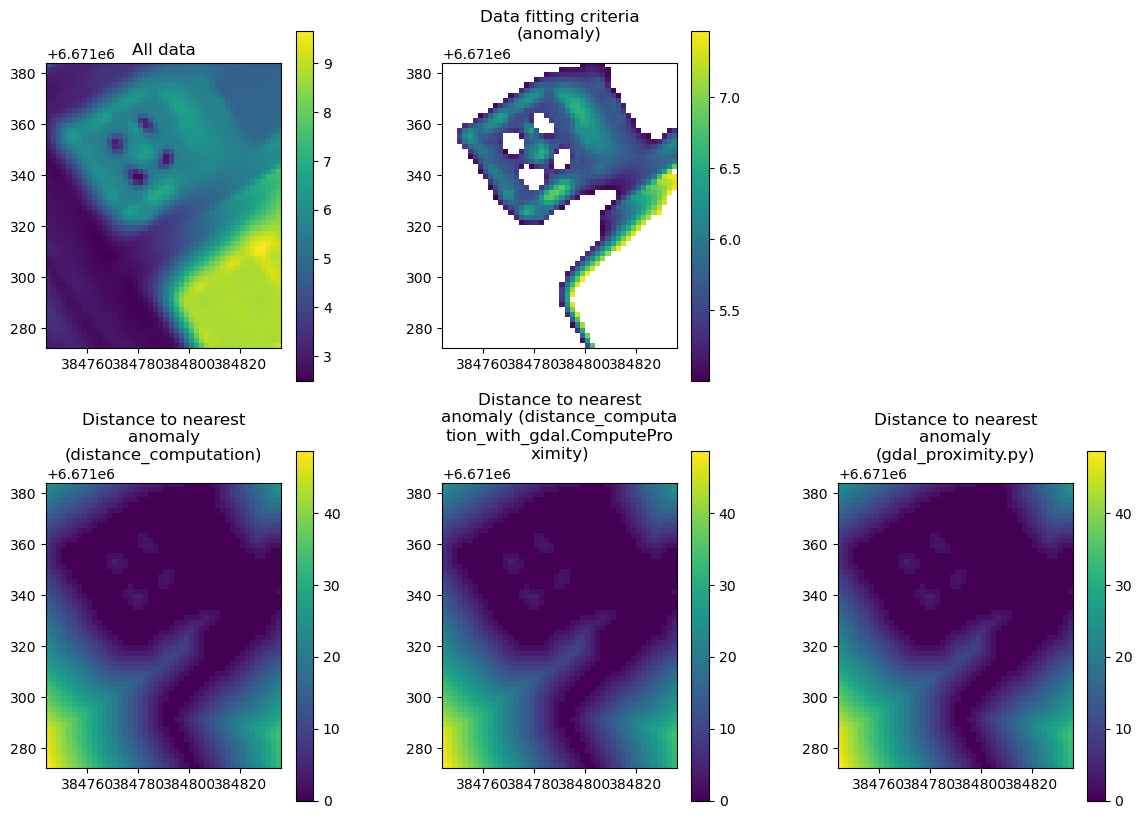

In [7]:
_plot_distance_example(
    threshold_criteria_value=(5.0, 7.5), threshold_criteria="in_between"
)

The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.5271260738372803 seconds
The time taken by gdal.ComputeProximity function to calculate the distance to anomaly is = 0.0016176700592041016 seconds
The time taken by gdal function to calculate the distance to anomaly is = 0.015779495239257812 seconds


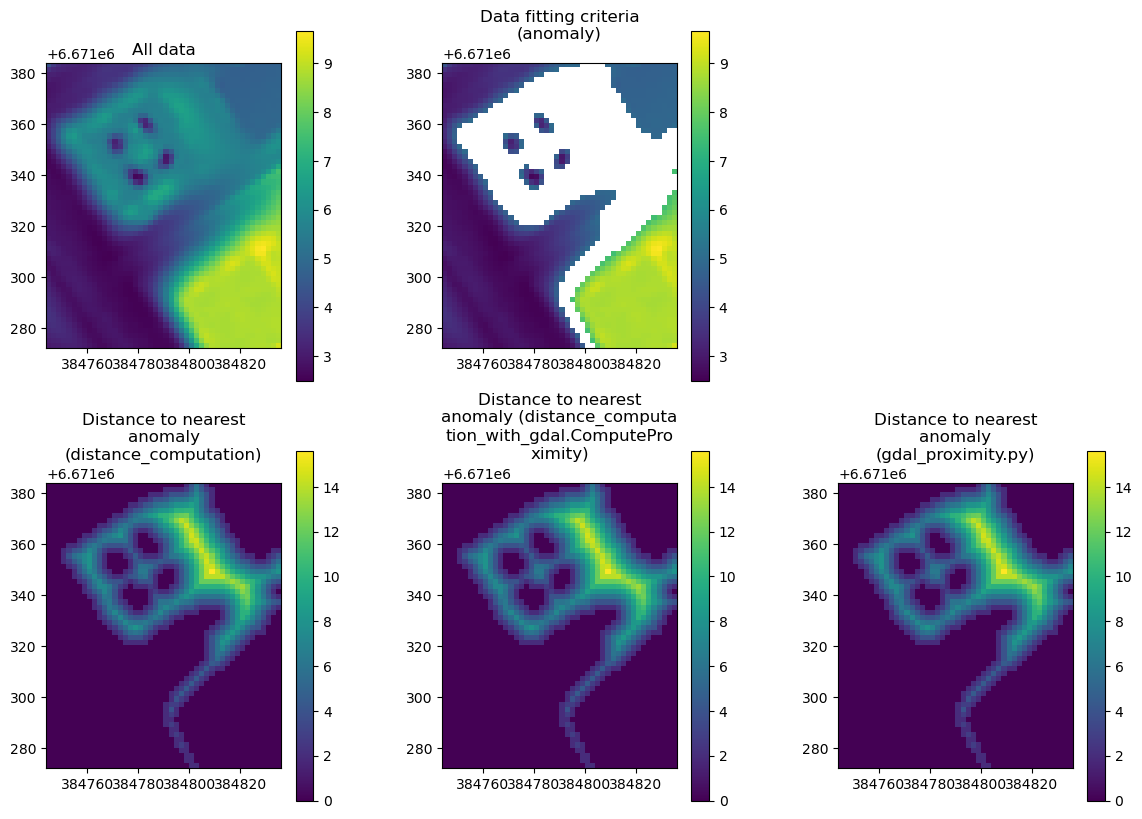

In [8]:
_plot_distance_example(
    threshold_criteria_value=(5.0, 7.5), threshold_criteria="outside"
)